In [41]:
import numpy as np
import random
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [10]:
# sigmoid function for nd; return the value of sigmoid with argument beta
# q can be n dimensional, either list or int/float
# beta should be between 0 and 1; determine the sharpness of sigmoid
# we can also try different functions here
def sigmoid(beta,q):
    q=np.array(q)
    val = 1/(1+np.exp(0-beta*q))
    return val
def ratchose(Q): # 0 means left
    if random.uniform(0,1)<sigmoid(beta,Q[0]-Q[1]):
        return np.array([1,0])
    else:
        return np.array([0,1]) 

In [138]:
# from Qlearning.ipynb
class toyQ_2choice:
    '''a unchanging env with probability of giving one
    of two rewards based on params to two different choices'''
    obs_size=1
    action_size=2
    def __init__(self,left=0.2,right=0.8,state=0):
        self.left=left
        self.right=right
        self.obslog=[]
        self.state=state
    def step(self,action,state=0):
        '''takes in the action param as a int of 0 or 1
        where 0 is go left and 1 is to right, and returns
        a return reward where 0 is no reward'''
        reward_site = random.uniform(0,1)
        if reward_site < self.right and np.array_equal(action,np.array([0,1])):
            #if the rat goes right and the reward is on the right
            obs=np.array([0,1])
        elif reward_site >= self.right and np.array_equal(action,np.array([1,0])):
            obs=np.array([1,0])
        else:
            obs=np.array([0,0])
        self.obslog.append(obs)
        return obs
    
class WSLS_rat: # to-do
    pass

class sig_rat:
    def __init__(self,env,alpha=0.2,beta=4,gamma=0):
        # alpha-learning rate, beta-sigmoid slop, gamma-discount factor of future reward
        '''Takes in the beta, gamma ,and the 
        environment of the rat'''
        self.choiceLog=[]
        self.beta=beta
        self.gamma=gamma
        self.env=env
        self.alpha=alpha
        self.action_size=env.action_size
        self.obs_size=env.obs_size
        self.Q=np.zeros((self.obs_size,)+(self.action_size,)) # Q-table starts from 0
        self.Qlog=np.zeros((self.obs_size,)+(self.action_size,))
    def get_choice(self): # 0 means left
        if random.uniform(0,1)<sigmoid(self.beta,self.Q[self.env.state][0]-self.Q[self.env.state][1]):
            self.choice=np.array([1,0])
        else:
            self.choice=np.array([0,1])
        self.choiceLog.append(self.choice)
        return self.choice
    def update(self,obs):
        '''Takes obs/reward and update its Q-table'''
        self.Q[self.env.state] = self.Q[self.env.state] + self.alpha*self.choice*\
        (obs + self.gamma*np.max(self.Q[self.env.state])-self.Q[self.env.state])
        self.Qlog=np.vstack((self.Qlog,self.Q))
        return self.Q[self.env.state]
    
class FSrat:
    def __init__(self,env,alphaF=0.2,alphaS=0.1,beta=4,gamma=0): # fail and success
        # alpha-learning rate, beta-sigmoid slop, gamma-discount factor of future reward
        '''Takes in the beta, gamma ,and the 
        environment of the rat'''
        self.choiceLog=[]
        self.beta=beta
        self.env=env
        self.alphaF=alphaF
        self.gamma=gamma
        self.alphaS=alphaS
        self.action_size=env.action_size
        self.obs_size=env.obs_size
        self.Q=np.zeros((self.obs_size,)+(self.action_size,)) # Q-table starts from 0
        self.Qlog=np.zeros((self.obs_size,)+(self.action_size,))
    def get_choice(self): #[1,0] means left
        if random.uniform(0,1)<sigmoid(self.beta,self.Q[self.env.state][0]-self.Q[self.env.state][1]):
            self.choice=np.array([1,0])
        else:
            self.choice=np.array([0,1])
        self.choiceLog.append(self.choice)
        return self.choice
    def update(self,obs):
        '''Takes obs/reward and update its Q-table'''
        used_alpha=[self.alphaF,self.alphaS][max(obs)]
        self.Q[self.env.state] = self.Q[self.env.state] + used_alpha*self.choice*\
        (obs + self.gamma*np.max(self.Q[self.env.state])-self.Q[self.env.state])
        self.Qlog=np.vstack((self.Qlog,self.Q))
        return self.Q[self.env.state]
    
    
    
def train_rat(env,rat,it_num,every=500):
    for i in range(it_num):
        action=rat.get_choice()
        obs=env.step(action)
        rat.update(obs)
        if i%every==-1:
            print(np.mean(rat.Qlog,axis=0))
    return env,rat


In [199]:
# demo
env=toyQ_2choice()
rat=sig_rat(env,alpha=0.2,beta=2)
env,rat=train_rat(env,rat,300)
obslog=np.array(env.obslog)
choicelog=np.array(rat.choiceLog) 
print('reward_log:',np.sum(obslog,axis=0))
print('choice_log:',np.sum(choicelog,axis=0))
rat.Q

reward_log: [ 14 179]
choice_log: [ 70 230]


array([[0.19680617, 0.97069267]])

In [200]:
actions = rat.choiceLog
rewards = env.obslog

## Maximum Likelihood Estimation on beta

we cannot give MLE for Q's since likelihood is a function of Q, that is, Q is changing at every timepoint

Given the actions(i.e. the turns) and Q value of the agent in every round, maximum likelihood estimation of beta are given here.

The action of agent is given by a sigmoid-like function of Q, beta as a parameter.

In [79]:
#for test use
#actions = np.random.choice([0,1], size=3, p=[0.2,0.8]) # 0=left, 1=right
#rewards = np.random.choice([0,1], size=3, p=[0.2,0.8])

In [24]:
#Q = np.array([[0,0],[0,0.2],[0.2,0.36]])    #,[0.36,0.688]
#beta0 = 0

In [184]:
# parameter: action, a list of numpy arrays of action data; reward, a list of np array of reward data
# beta, sharpness of sigmoid; alpha, learning rate
# return the sum of log-likelihood
def neg_log_likelihood(alpha,beta,actions,rewards,Q=[0,0],gamma=0): 
    n = len(actions)
    sum_ll = 0
    for i in range(n):
        turn = actions[i]
        rew = rewards[i]
        Q = Q + alpha*turn*(rew + gamma*np.max(Q)-Q)
        dQ = Q[0] - Q[1]
        if np.array_equal(turn,np.array([1,0])):
            prob = 1/(np.exp(0-beta*dQ)+1)
        else:
            prob = 1 - 1/(np.exp(0-beta*dQ)+1)
        
        sum_ll = sum_ll - np.log(prob + np.exp(0-8)) # add a smoother to avoid warnings
    
    return sum_ll

In [222]:
bvals = np.linspace(0,10,50)
avals = np.linspace(0,1,200)
# ll = [neg_log_likelihood(0.2,b,actions,rewards) for b in bvals]
ll = [neg_log_likelihood(a,2,actions,rewards) for a in avals]

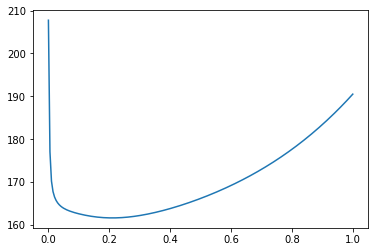

In [223]:
# plt.plot(bvals, ll)
plt.plot(avals, ll)
plt.show()

In [219]:
print(avals[0:5])
print(ll[0:5])

[0.         0.02040816 0.04081633 0.06122449 0.08163265]
[207.74294408216213, 185.95897476133842, 188.29541666886894, 188.04222343719303, 187.73789498441752]


In [214]:
resvec = [minimize(helper_func,[a0,0.1],args=[actions,rewards]) for a0 in np.linspace(0.05,1,10)]

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


In [215]:
[resvec[i].x for i in range(10)]

[array([0.20789271, 2.06412972]),
 array([0.20789267, 2.06413056]),
 array([0.20789269, 2.0641296 ]),
 array([0.20789269, 2.06413004]),
 array([0.20789267, 2.06413003]),
 array([0.20789275, 2.06413003]),
 array([0.20789267, 2.06413008]),
 array([0.20789267, 2.06413043]),
 array([0.20789269, 2.06413065]),
 array([0.20789267, 2.06413006])]

In [213]:
[resvec[i].x for i in range(10)]

[array([0.20789274, 2.06413008]),
 array([0.20789275, 2.06413062]),
 array([0.20789266, 2.06412995]),
 array([0.20789271, 2.06413014]),
 array([0.2078927 , 2.06412976]),
 array([0.20789272, 2.06413012]),
 array([0.20789264, 2.06413017]),
 array([0.20789264, 2.06412988]),
 array([0.20789271, 2.06413015]),
 array([0.20789267, 2.06413032])]

In [153]:
# params = [alpha0,beta0]
# args = [actions,rewards]
def helper_func(params,args):
    alpha0 = params[0]
    beta0 = params[1]
    actions = args[0]
    rewards = args[1]
    
    sum_ll = neg_log_likelihood(alpha0,beta0,actions,rewards)
    
    return sum_ll

In [117]:
# function that estimates the maximum-likelihood beta_hat numerically
# parameters: actions, a numpy array recording action of agent in each turn; beta is the parameter in density func
# return minimization summary and print beta_hat
def MLE_grid(actions,rewards,alpha0,beta0):
    initial_guess = [alpha0,beta0]
    args = [actions,rewards]
    result = minimize(helper_func,initial_guess,args=args)
    if(result.success):
        #print(result.message)
        #print('The MLE for beta is', result.x)
        #print('Iteration =', result.nit)
        a=0
    else:
        print('The optimization did not converge, beta0 equals', beta0,', and alpha0 equals',alpha0)
    return result
    
    

In [105]:
# return mse between simulated Q and Q_hat calculated with optimal beta from MLE
def Q_distance(iteration,alpha0,beta0):
    env = toyQ_2choice()
    rat = sig_rat(env, alpha=alpha0, beta=beta0)
    env,rat = train_rat(env,rat,iteration)
    Q = np.array(rat.Qlog)
    actions = rat.choiceLog
    rewards = env.obslog
    
    result = MLE_grid(actions,rewards,alpha0,beta0)
    alpha_hat = result.x[0]
    beta_hat = result.x[1]
    
    rat_hat = sig_rat(env, alpha=alpha_hat, beta=beta_hat)
    env,rat_hat = train_rat(env,rat_hat,iteration)
    Q_hat = np.array(rat_hat.Qlog)
    
    #Q[0]=[0,0] does not matter
    mse = np.linalg.norm(Q-Q_hat)**2/iteration 
    #axis=None perform mean elementwise   (np.square(Q-Q_hat)).mean(axis=None)*2
    
    return mse
    
    

In [115]:
#test
Q_distance(300,0.2,4)

0.06082295529941778

In [118]:
#
mse_list = []
beta0_list = [-10,-4,-2,-1,-0.8,-0.5,-0.2,0.2,0.5,0.8,1,2,4,10]
alpha0_list = [0.1,0.3,0.5,0.7,0.9]
iteration=300
for i in range(len(beta0_list)):
    for j in range(len(alpha0_list)):
        mse = Q_distance(iteration,alpha0_list[j],beta0_list[i])
        mse_list.append(mse)

The optimization did not converge, beta0 equals -10 , and alpha0 equals 0.1


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1 , and alpha0 equals 0.9


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.5 , and alpha0 equals 0.1
The optimization did not converge, beta0 equals -0.5 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.3
The optimization did not converge, beta0 equals -0.5 , and alpha0 equals 0.5

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 0.2 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.7
The optimization did not converge, beta0 equals 0.5 , and alpha0 equals 0.3
The optimization did not converge, beta0 equals 0.8 , and alpha0 equals 0.1


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 10 , and alpha0 equals 0.7


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


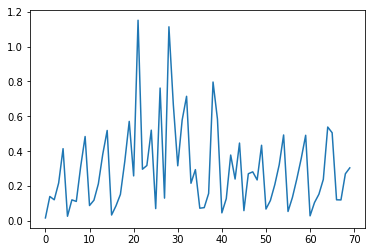

In [120]:
import matplotlib.pyplot as plt
plt.plot(mse_list)
plt.show()

In [121]:
# return the optimal combination of alpha and beta that gives smallest mse between Q and Q_hat
def opt_alpha_beta(mse_list,alpha_list,beta_list):
    n = len(alpha_list)
    m = len(beta_list)
    
    mse_min = min(mse_list)
    
    for i in range(m):
        for j in range(n):
            if mse_list[(i-1)*n + j] == mse_min:
                return alpha_list[j],beta_list[i]
            
    

0.017995139521162173

In [122]:
# larger test
beta0_list2 = np.linspace(-10,10,100)
alpha0_list2 = np.linspace(0,1,100)
mse_list2 = []
iteration=300
for i in range(len(beta0_list2)):
    for j in range(len(alpha0_list2)):
        mse = Q_distance(iteration,alpha0_list2[j],beta0_list2[i])
        mse_list2.append(mse)

The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 0.020202020202020204

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 0.14141414141414144
The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 0.19191919191919193
The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 0.8080808080808082
The optimization did not converge, beta0 equals -10.0 , and alpha0 equals 1.0
The optimization did not converge, beta0 equals -9.797979797979798 , and alpha0 equals 0.0

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -9.797979797979798 , and alpha0 equals 0.010101010101010102

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -9.797979797979798 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -9.797979797979798 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -9.797979797979798 , and alpha0 equals 0.04040404040404041


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -9.797979797979798 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -9.797979797979798 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -9.797979797979798 , and alpha0 equals 0.26262626262626265
The optimization did not converge, beta0 equals -9.797979797979798 , and alpha0 equals 0.9797979797979799

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -9.595959595959595 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -9.595959595959595 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -9.595959595959595 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -9.595959595959595 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -9.595959595959595 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -9.595959595959595 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -9.595959595959595 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -9.595959595959595 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -9.595959595959595 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -9.595959595959595 , and alpha0 equals 0.12121212121212122
The optimization did not converge, beta0 equals -9.595959595959595 , and alpha0 equals 0.14141414141414144
The optimization did not converge, 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.8989898989898991
The optimization did not converge, beta0 equals -9.393939393939394 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.0
The optimization did not converge, beta0 equals -9.393939393939394 , and alpha0 equals 0.010101010101010102

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -9.393939393939394 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -9.393939393939394 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -9.393939393939394 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -9.393939393939394 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.08080808080808081
The optimization did not converge, beta0 equals -9.393939393939394 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


 0.09090909090909091
The optimization did not converge, beta0 equals -9.393939393939394 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals -9.393939393939394 , and alpha0 equals 0.8585858585858587
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.05050505050505051
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals 0.14141414141414144
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals 0.15151515151515152
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals 0.17171717171717174
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.22222222222222224
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals 0.6262626262626263
The optimization did not converge, beta0 equals -9.191919191919192 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.9090909090909092
The optimization did not converge, beta0 equals -8.98989898989899 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -8.98989898989899 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -8.98989898989899 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -8.98989898989899 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals -8.98989898989899 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -8.98989898989899 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -8.98989898989899 , and alpha0 equals 0.12121212121212122
The optimization did not converge, beta0 equals -8.98989898989899 , and alpha0 equals 0.15151515151515152
The optimization did not converge, beta0 equals -8.98989898989899 , and alpha0 equals 0.18181818181818182


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -8.98989898989899 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals -8.787878787878787 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -8.787878787878787 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -8.787878787878787 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -8.787878787878787 , and alpha0 equals 0.06060606060606061


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -8.787878787878787 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -8.787878787878787 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals -8.787878787878787 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals -8.787878787878787 , and alpha0 equals 0.16161616161616163


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.030303030303030304
The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 0.14141414141414144
The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 0.18181818181818182
The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 0.38383838383838387
The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals -8.585858585858587 , and alpha0 equals 0.9696969696969697


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -8.383838383838384 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -8.383838383838384 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -8.383838383838384 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -8.383838383838384 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -8.383838383838384 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -8.383838383838384 , and alpha0 equals 1.0
The optimization did not converge, beta0 equals -8.181818181818182 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -8.181818181818182 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -8.181818181818182 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -8.181818181818182 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -8.181818181818182 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -8

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -8.181818181818182 , and alpha0 equals 0.9494949494949496
The optimization did not converge, beta0 equals -8.181818181818182 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals -8.181818181818182 , and alpha0 equals 0.98989898989899


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -7.979797979797979 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -7.979797979797979 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -7.979797979797979 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -7.979797979797979 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -7.979797979797979 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -7.979797979797979 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


, and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -7.979797979797979 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals -7.979797979797979 , and alpha0 equals 0.10101010101010102

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -7.979797979797979 , and alpha0 equals 0.19191919191919193
The optimization did not converge, beta0 equals -7.979797979797979 , and alpha0 equals 0.22222222222222224
The optimization did not converge, beta0 equals -7.777777777777778 , and alpha0 equals 0.0

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -7.777777777777778 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.010101010101010102
The optimization did not converge, beta0 equals -7.777777777777778 , and alpha0 equals 0.04040404040404041

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -7.777777777777778 , and alpha0 equals 0.05050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -7.777777777777778 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -7.777777777777778 , and alpha0 equals 0.3535353535353536
The optimization did not converge, beta0 equals -7.777777777777778 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.12121212121212122
The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.36363636363636365
The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.7373737373737375
The optimization did not converge, beta0 equals -7.575757575757576 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.020202020202020204
The optimization did not converge, beta0 equals -7.373737373737374 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -7.373737373737374 , and alpha0 equals 0.04040404040404041

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -7.373737373737374 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -7.373737373737374 , and alpha0 equals 0.14141414141414144
The optimization did not converge, beta0 equals -7.373737373737374 , and alpha0 equals 0.15151515151515152
The optimization did not converge, beta0 equals -7.373737373737374 , and alpha0 equals 0.21212121212121213
The optimization did not converge, beta0 equals -7.373737373737374 , and alpha0 equals 0.33333333333333337
The optimization did not converge, beta0 equals -7.373737373737374 , and alpha0 equals 0.48484848484848486
The optimization did not converge, beta0 equals -7.373737373737374 , and alpha0 equals 0.5050505050505051
The optimization did not converge, beta0 equals -7.373737373737374 , and alpha0 equals 1.0
The optimization did not converge, beta0 equals -7.171717171717171

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -7.171717171717171 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -7.171717171717171 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -7.171717171717171 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.05050505050505051
The optimization did not converge, beta0 equals -7.171717171717171 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -7.171717171717171 , and alpha0 equals 0.2828282828282829
The optimization did not converge, beta0 equals -7.171717171717171 , and alpha0 equals 0.8181818181818182
The optimization did not converge, beta0 equals -7.171717171717171 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals -6.96969696969697 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -6.96969696969697 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -6.96969696969697 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -6.96969696969697 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -6.96969696969697 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.08080808080808081
The optimization did not converge, beta0 equals -6.96969696969697 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -6.96969696969697 , and alpha0 equals 0.16161616161616163
The optimization did not converge, beta0 equals -6.96969696969697 , and alpha0 equals 0.17171717171717174
The optimization did not converge, beta0 equals -6.96969696969697 , and alpha0 equals 1.0

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -6.767676767676768 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -6.767676767676768

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -6.767676767676768 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -6.767676767676768 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -6.767676767676768 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -6.767676767676768 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals -6.767676767676768 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -6.767676767676768 , and alpha0 equals 0.8585858585858587
The optimization did not converge, beta0 equals -6.767676767676768 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals -6.767676767676768 , and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals -6.565656565656566 , and alpha0 equals 0.0
The optimizat

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -6.565656565656566 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -6.565656565656566 , and alpha0 equals 0.12121212121212122
The optimization did not converge, beta0 equals -6.565656565656566 , and alpha0 equals 0.15151515151515152
The optimization did not converge, beta0 equals -6.565656565656566 , and alpha0 equals 0.32323232323232326
The optimization did not converge, beta0 equals -6.565656565656566 , and alpha0 equals 0.9797979797979799


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -6.363636363636363 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -6.363636363636363 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -6.363636363636363 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -6.363636363636363 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -6.363636363636363 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals -6.363636363636363 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -6.363636363636363 , and alpha0 equals 0.16161616161616163
The optimization did not converge, beta0 equals -6.161616161616162 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -6.161616161616162 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.010101010101010102
The optimization did not converge, beta0 equals -6.161616161616162 , and alpha0 equals 0.020202020202020204

/Users/erika/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))



The optimization did not converge, beta0 equals -6.161616161616162 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -6.161616161616162 , and alpha0 equals 0.04040404040404041


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -6.161616161616162 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -6.161616161616162 , and alpha0 equals 0.15151515151515152
The optimization did not converge, beta0 equals -6.161616161616162 , and alpha0 equals 0.5151515151515152
The optimization did not converge, beta0 equals -6.161616161616162 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals -6.161616161616162 , and alpha0 equals 0.9494949494949496
The optimization did not converge, beta0 equals -6.161616161616162 , and alpha0 equals 0.98989898989899
The optimization did not converge, beta0 equals -5.959595959595959 , and alpha0 equals 0.0

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -5.959595959595959 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -5.959595959595959 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -5.959595959595959 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -5.959595959595959 , and alpha0 equals 0.05050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -5.959595959595959 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -5.959595959595959 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.08080808080808081
The optimization did not converge, beta0 equals -5.959595959595959 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -5.959595959595959 , and alpha0 equals 0.22222222222222224


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -5.959595959595959 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.9595959595959597
The optimization did not converge, beta0 equals -5.757575757575758 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -5.757575757575758 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.020202020202020204
The optimization did not converge, beta0 equals -5.757575757575758 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -5.757575757575758 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -5.757575757575758 , and alpha0 equals 0.06060606060606061

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -5.757575757575758 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals -5.757575757575758 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals -5.757575757575758 , and alpha0 equals 0.494949494949495
The optimization did not converge, beta0 equals -5.757575757575758 , and alpha0 equals 0.5757575757575758
The optimization did not converge, beta0 equals -5.757575757575758 , and alpha0 equals 0.8585858585858587
The optimization did not converge, beta0 equals -5.757575757575758 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals -5.555555555555555 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.0
The optimization did not converge, beta0 equals -5.555555555555555 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -5.555555555555555 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -5.555555555555555 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -5.555555555555555 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -5.555555555555555 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -5.555555555555555 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -5.555555555555555 , and alpha0 equals 0.10101010101010102

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -5.555555555555555 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.9090909090909092
The optimization did not converge, beta0 equals -5.353535353535354 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.0
The optimization did not converge, beta0 equals -5.353535353535354 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -5.353535353535354 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -5.353535353535354 , and alpha0 equals 0.030303030303030304

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -5.353535353535354 , and alpha0 equals 0.06060606060606061

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -5.353535353535354 , and alpha0 equals 0.38383838383838387


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals 0.05050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.18181818181818182
The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals 0.27272727272727276


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals 0.4141414141414142
The optimization did not converge, beta0 equals -5.151515151515151 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.797979797979798
The optimization did not converge, beta0 equals -4.94949494949495 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -4.94949494949495 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -4.94949494949495 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -4.94949494949495 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -4.94949494949495 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals -4.94949494949495 , and alpha0 equals 0.09090909090909091


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -4.94949494949495 , and alpha0 equals 0.4141414141414142
The optimization did not converge, beta0 equals -4.94949494949495 , and alpha0 equals 0.4444444444444445
The optimization did not converge, beta0 equals -4.94949494949495 , and alpha0 equals 0.5151515151515152
The optimization did not converge, beta0 equals -4.94949494949495 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.9090909090909092
The optimization did not converge, beta0 equals -4.747474747474747 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -4.747474747474747 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -4.747474747474747 , and alpha0 equals 0.04040404040404041

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -4.747474747474747 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -4.747474747474747 , and alpha0 equals 0.06060606060606061


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -4.747474747474747 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals -4.747474747474747 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals -4.747474747474747 , and alpha0 equals 0.12121212121212122
The optimization did not converge, beta0 equals -4.747474747474747 , and alpha0 equals 0.16161616161616163
The optimization did not converge, beta0 equals -4.747474747474747 , and alpha0 equals 0.30303030303030304

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -4.747474747474747 , and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.11111111111111112

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.15151515151515152
The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.17171717171717174
The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.30303030303030304
The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.7171717171717172
The optimization did not converge, beta0 equals -4.545454545454546 , and alpha0 equals 0.7474747474747475


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -4.343434343434343 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -4.343434343434343 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -4.343434343434343 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -4.343434343434343 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -4.343434343434343 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals -4.343434343434343 , and alpha0 equals 0.18181818181818182
The optimization did not converge, beta0 equals -4.343434343434343 , and alpha0 equals 0.24242424242424243
The optimization did not converge, beta0 equals -4.343434343434343 , and alpha0 equals 0.29292929292929293
The optimization did not converge, beta0 equals -4.343434343434343 , and alpha0 equals 0.7272727272727273
The optimization did not converge, beta0 equals -4.343434343434343 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -4.141414141414142 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals -4.141414141414142 , and alpha0 equals 0.16161616161616163
The optimization did not converge, beta0 equals -4.141414141414142 , and alpha0 equals 0.17171717171717174
The optimization did not converge, beta0 equals -4.141414141414142 , and alpha0 equals 0.21212121212121213
The optimization did not converge, beta0 equals -4.141414141414142 , and alpha0 equals 0.8686868686868687
The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 0.04040404040404041


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 0.5050505050505051
The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals -3.9393939393939394 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.98989898989899
The optimization did not converge, beta0 equals -3.737373737373738 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.737373737373738 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -3.737373737373738 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.030303030303030304
The optimization did not converge, beta0 equals -3.737373737373738 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -3.737373737373738 , and alpha0 equals 0.11111111111111112


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.737373737373738 , and alpha0 equals 0.29292929292929293


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.04040404040404041


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.05050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.11111111111111112


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.12121212121212122


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.14141414141414144
The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.5858585858585859
The optimization did not converge, beta0 equals -3.5353535353535355 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals -3.333333333333333 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.333333333333333 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -3.333333333333333 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.020202020202020204
The optimization did not converge, beta0 equals -3.333333333333333 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -3.333333333333333 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -3.333333333333333 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -3.333333333333333 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -3.333333333333333 , and alpha0 equals 0.14141414141414144
The optimization did not converge, beta0 equals -3.333333333333333 , and alpha0 equals 0.4444444444444445
The optimization did not converge, beta0 equals -3.333333333333333 , and alpha0 equals 0.9191919191919192


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.1313131313131315 , and alpha0 equals 0.0

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -3.1313131313131315 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -3.1313131313131315 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.1313131313131315 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.1313131313131315 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -3.1313131313131315 , and alpha0 equals 0.05050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -3.1313131313131315 , and alpha0 equals 0.17171717171717174
The optimization did not converge, beta0 equals -3.1313131313131315

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 , and alpha0 equals 0.21212121212121213
The optimization did not converge, beta0 equals -2.929292929292929 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.0
The optimization did not converge, beta0 equals -2.929292929292929 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -2.929292929292929 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -2.929292929292929 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -2.929292929292929 , and alpha0 equals 0.14141414141414144


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -2.929292929292929 , and alpha0 equals 0.17171717171717174
The optimization did not converge, beta0 equals -2.929292929292929 , and alpha0 equals 0.30303030303030304
The optimization did not converge, beta0 equals -2.929292929292929 , and alpha0 equals 1.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -2.7272727272727275 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -2.7272727272727275 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -2.7272727272727275 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.020202020202020204
The optimization did not converge, beta0 equals -2.7272727272727275 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -2.7272727272727275 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.08080808080808081
The optimization did not converge, beta0 equals -2.7272727272727275 , and alpha0 equals 0.24242424242424243
The optimization did not converge, beta0 equals -2.7272727272727275 , and alpha0 equals 0.2828282828282829
The optimization did not converge, beta0 equals -2.7272727272727275 , and alpha0 equals 0.696969696969697
The optimization did not converge, beta0 equals -2.7272727272727275 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.7171717171717172
The optimization did not converge, beta0 equals -2.525252525252525 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -2.525252525252525 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -2.525252525252525 , and alpha0 equals 0.020202020202020204

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -2.525252525252525 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -2.525252525252525 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -2.525252525252525 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -2.525252525252525 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals -2.525252525252525 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals -2.525252525252525 , and alpha0 equals 0.11111111111111112


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -2.525252525252525 , and alpha0 equals 0.6060606060606061

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -2.3232323232323235 , and alpha0 equals 0.0

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -2.3232323232323235 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -2.3232323232323235 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals -2.3232323232323235 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals -2.3232323232323235 , and alpha0 equals 0.14141414141414144


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -2.3232323232323235 , and alpha0 equals 0.20202020202020204
The optimization did not converge, beta0 equals -2.3232323232323235 , and alpha0 equals 0.26262626262626265


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -2.3232323232323235 , and alpha0 equals 0.4545454545454546
The optimization did not converge, beta0 equals -2.121212121212121 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -2.121212121212121 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -2.121212121212121 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.04040404040404041
The optimization did not converge, beta0 equals -2.121212121212121 , and alpha0 equals 0.18181818181818182


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -2.121212121212121 , and alpha0 equals 0.37373737373737376
The optimization did not converge, beta0 equals -2.121212121212121 , and alpha0 equals 0.494949494949495
The optimization did not converge, beta0 equals -2.121212121212121 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals -1.9191919191919187 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals -1.9191919191919187 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -1.9191919191919187 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


, and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals -1.9191919191919187 , and alpha0 equals 0.05050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.9191919191919187 , and alpha0 equals 0.06060606060606061


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.9191919191919187 , and alpha0 equals 0.4040404040404041
The optimization did not converge, beta0 equals -1.9191919191919187 , and alpha0 equals 0.4444444444444445
The optimization did not converge, beta0 equals -1.9191919191919187 , and alpha0 equals 0.5050505050505051
The optimization did not converge, beta0 equals -1.9191919191919187 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


, and alpha0 equals 0.5858585858585859
The optimization did not converge, beta0 equals -1.9191919191919187 , and alpha0 equals 0.787878787878788
The optimization did not converge, beta0 equals -1.9191919191919187 , and alpha0 equals 0.888888888888889


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.0
The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.05050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.10101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.17171717171717174


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.33333333333333337
The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.4545454545454546
The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.494949494949495
The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals -1.717171717171718 , and alpha0 equals 0.98989898989899


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.0
The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.05050505050505051
The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.08080808080808081


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.12121212121212122
The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.13131313131313133


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.17171717171717174


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.27272727272727276
The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.43434343434343436
The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.5656565656565657
The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.6464646464646465
The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.7272727272727273
The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.888888888888889
The optimization did not converge, beta0 equals -1.5151515151515156 , and alpha0 equals 0.98989898989899


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.3131313131313131 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.3131313131313131 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.3131313131313131 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -1.3131313131313131 , and alpha0 equals 0.12121212121212122


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.3131313131313131 , and alpha0 equals 0.15151515151515152
The optimization did not converge, beta0 equals -1.3131313131313131 , and alpha0 equals 0.3434343434343435


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.3131313131313131 , and alpha0 equals 0.595959595959596
The optimization did not converge, beta0 equals -1.3131313131313131 , and alpha0 equals 0.6262626262626263


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.3131313131313131 , and alpha0 equals 0.6666666666666667


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -1.3131313131313131 , and alpha0 equals 0.7777777777777778
The optimization did not converge, beta0 equals -1.3131313131313131 , and alpha0 equals 0.8383838383838385


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 0.010101010101010102

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.05050505050505051
The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 0.08080808080808081


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.1111111111111107

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.12121212121212122
The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 0.27272727272727276
The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 0.32323232323232326


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.43434343434343436
The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 0.5656565656565657
The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 0.6060606060606061
The optimization did not converge, beta0 equals -1.1111111111111107 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.6666666666666667
The optimization did not converge, beta0 equals -0.9090909090909101 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.9090909090909101 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.9090909090909101 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.9090909090909101 , and alpha0 equals 0.04040404040404041


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.9090909090909101 , and alpha0 equals 0.08080808080808081


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.9090909090909101 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals -0.9090909090909101 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


, and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals -0.9090909090909101 , and alpha0 equals 0.25252525252525254


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.9090909090909101 , and alpha0 equals 0.6767676767676768
The optimization did not converge, beta0 equals -0.9090909090909101 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


, and alpha0 equals 0.7676767676767677
The optimization did not converge, beta0 equals -0.9090909090909101 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals -0.9090909090909101 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.8787878787878789
The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.010101010101010102

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.04040404040404041
The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.06060606060606061


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.08080808080808081


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.11111111111111112

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.19191919191919193


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.22222222222222224


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.23232323232323235


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.37373737373737376


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.6464646464646465
The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.686868686868687
The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 0.7575757575757577
The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.797979797979798
The optimization did not converge, beta0 equals -0.7070707070707076 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.8181818181818182
The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.10101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.15151515151515152
The optimization did not converge, beta0 equals -0.5050505050505052 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.17171717171717174
The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.22222222222222224


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.32323232323232326


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.3434343434343435


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.4545454545454546
The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.5656565656565657


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.6161616161616162


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.6464646464646465


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.7070707070707072


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.8181818181818182


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.5050505050505052 , and alpha0 equals 0.888888888888889


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.10101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.11111111111111112


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.12121212121212122

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.13131313131313133


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.15151515151515152


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.32323232323232326


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.43434343434343436


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.5858585858585859


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.6161616161616162


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.6767676767676768


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.686868686868687


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.797979797979798


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.8585858585858587


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.8686868686868687


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.8787878787878789


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals -0.30303030303030276 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.0
The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.04040404040404041


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.08080808080808081


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.15151515151515152


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.17171717171717174


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.21212121212121213
The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.29292929292929293


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.32323232323232326


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.3535353535353536
The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.36363636363636365


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.48484848484848486


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.494949494949495
The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.5050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.5454545454545455


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.5757575757575758


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.595959595959596
The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.6363636363636365


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.7272727272727273


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.7777777777777778


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.797979797979798


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.8585858585858587


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.888888888888889


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals -0.10101010101010033 , and alpha0 equals 0.9090909090909092


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.05050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.10101010101010033 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


, and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.19191919191919193
The optimization did not converge, beta0 equals 0.10101010101010033

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.20202020202020204
The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.21212121212121213


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.25252525252525254
The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.27272727272727276
The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.2828282828282829


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.3434343434343435


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.3535353535353536
The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.37373737373737376
The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.4444444444444445

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.4545454545454546

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.5050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.10101010101010033

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 , and alpha0 equals 0.5252525252525253
The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.5454545454545455
The optimization did not converge, beta0 equals 0.10101010101010033 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


, and alpha0 equals 0.5757575757575758
The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.6363636363636365
The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.6666666666666667


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.7777777777777778

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.787878787878788

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals 0.797979797979798

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals 0.10101010101010033 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.8787878787878789
The optimization did not converge, beta0 equals 0.10101010101010033 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.9292929292929294
The optimization did not converge, beta0 equals 0.10101010101010033 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.9797979797979799
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.30303030303030276 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.06060606060606061


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.07070707070707072


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.11111111111111112
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.13131313131313133


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.20202020202020204
The optimization did not converge, beta0 equals 0.30303030303030276 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.22222222222222224
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.23232323232323235
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.30303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.31313131313131315
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.33333333333333337


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.3434343434343435
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.42424242424242425
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.5353535353535354
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.5656565656565657
The optimization did not converge, beta0 equals 0.30303030303030276

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 , and alpha0 equals 0.5757575757575758
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.595959595959596
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.6363636363636365
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.6464646464646465
The optimization did not converge, beta0 equals 0.30303030303030276 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


, and alpha0 equals 0.6767676767676768
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.7474747474747475
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.7575757575757577

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.7777777777777778
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 0.30303030303030276 , and alpha0 equals 0.8686868686868687


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.010101010101010102
The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 0.08080808080808081


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.11111111111111112
The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 0.18181818181818182


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.31313131313131315
The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 0.36363636363636365
The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.4444444444444445
The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 0.686868686868687
The optimization did not converge, beta0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.5050505050505052 , and alpha0 equals 0.7474747474747475
The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 0.8282828282828284
The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 0.9090909090909092

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 0.9191919191919192


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 0.5050505050505052 , and alpha0 equals 0.98989898989899
The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals 0.7070707070707076 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


, and alpha0 equals 0.12121212121212122
The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.19191919191919193
The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.20202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.21212121212121213

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.29292929292929293


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.3434343434343435
The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.36363636363636365


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.38383838383838387
The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.42424242424242425


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.5050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.5252525252525253
The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.5555555555555556
The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.595959595959596


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.797979797979798
The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.888888888888889
The optimization did not converge, beta0 equals 0.7070707070707076 , and alpha0 equals 0.9191919191919192


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 0.9090909090909083 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.0
The optimization did not converge, beta0 equals 0.9090909090909083 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 0.9090909090909083 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 0.9090909090909083 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 0.9090909090909083 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals 0.9090909090909083 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals 0.9090909090909083 , and alpha0 equals 0.16161616161616163


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 0.9090909090909083 , and alpha0 equals 0.20202020202020204
The optimization did not converge, beta0 equals 0.9090909090909083 , and alpha0 equals 0.27272727272727276
The optimization did not converge, beta0 equals 0.9090909090909083 , and alpha0 equals 0.7474747474747475
The optimization did not converge, beta0 equals 0.9090909090909083 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 1.1111111111111107 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 1.1111111111111107 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 1.1111111111111107 , and alpha0 equals 0.04040404040404041


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 1.1111111111111107 , and alpha0 equals 0.23232323232323235
The optimization did not converge, beta0 equals 1.1111111111111107 , and alpha0 equals 0.33333333333333337
The optimization did not converge, beta0 equals 1.1111111111111107 , and alpha0 equals 0.4444444444444445
The optimization did not converge, beta0 equals 1.1111111111111107 , and alpha0 equals 0.696969696969697
The optimization did not converge, beta0 equals 1.1111111111111107 , and alpha0 equals 0.8080808080808082


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 1.3131313131313131 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 1.3131313131313131 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


1.3131313131313131 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals 1.3131313131313131

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.12121212121212122
The optimization did not converge, beta0 equals 1.3131313131313131 , and alpha0 equals 0.18181818181818182
The optimization did not converge, beta0 equals 1.3131313131313131

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.21212121212121213
The optimization did not converge, beta0 equals 1.3131313131313131 , and alpha0 equals 0.32323232323232326
The optimization did not converge, beta0 equals 1.3131313131313131 , and alpha0 equals 0.393939393939394
The optimization did not converge, beta0 equals 1.3131313131313131 , and alpha0 equals 0.4545454545454546
The optimization did not converge, beta0 equals 1.3131313131313131 , and alpha0 equals 0.48484848484848486
The optimization did not converge, beta0 equals 1.3131313131313131 , and alpha0 equals 0.5757575757575758
The optimization did not converge, beta0 equals 1.3131313131313131 , and alpha0 equals 0.8181818181818182
The optimization did not converge, beta0 equals 1.5151515151515156 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


0.0
The optimization did not converge, beta0 equals 1.5151515151515156 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 1.5151515151515156 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals 1.5151515151515156 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals 1.5151515151515156 , and alpha0 equals 0.13131313131313133

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 1.5151515151515156 , and alpha0 equals 0.4040404040404041
The optimization did not converge, beta0 equals 1.5151515151515156 , and alpha0 equals 0.4444444444444445
The optimization did not converge, beta0 equals 1.5151515151515156 , and alpha0 equals 0.4747474747474748
The optimization did not converge, beta0 equals 1.5151515151515156 , and alpha0 equals 0.6666666666666667
The optimization did not converge, beta0 equals 1.5151515151515156 , and alpha0 equals 0.6767676767676768
The optimization did not converge, beta0 equals 1.5151515151515156 , and alpha0 equals 0.7575757575757577
The optimization did not converge, beta0 equals 1.5151515151515156 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.8080808080808082
The optimization did not converge, beta0 equals 1.7171717171717162 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 1.7171717171717162 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.010101010101010102
The optimization did not converge, beta0 equals 1.7171717171717162 , and alpha0 equals 0.13131313131313133

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 1.7171717171717162 , and alpha0 equals 0.4545454545454546
The optimization did not converge, beta0 equals 1.7171717171717162 , and alpha0 equals 0.6060606060606061
The optimization did not converge, beta0 equals 1.7171717171717162 , and alpha0 equals 0.7272727272727273
The optimization did not converge, beta0 equals 1.7171717171717162 , and alpha0 equals 0.8686868686868687
The optimization did not converge, beta0 equals 1.7171717171717162 , and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 1.7171717171717162 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 1.9191919191919187 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals 1.9191919191919187 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals 1.9191919191919187

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 , and alpha0 equals 0.15151515151515152
The optimization did not converge, beta0 equals 1.9191919191919187 , and alpha0 equals 0.32323232323232326


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 1.9191919191919187 , and alpha0 equals 0.4444444444444445
The optimization did not converge, beta0 equals 1.9191919191919187 , and alpha0 equals 0.6767676767676768
The optimization did not converge, beta0 equals 1.9191919191919187 , and alpha0 equals 0.9090909090909092


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 2.121212121212121 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.0
The optimization did not converge, beta0 equals 2.121212121212121 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 2.121212121212121 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 2.121212121212121 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals 2.121212121212121 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals 2.121212121212121 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.18181818181818182
The optimization did not converge, beta0 equals 2.121212121212121 , and alpha0 equals 0.33333333333333337
The optimization did not converge, beta0 equals 2.121212121212121 , and alpha0 equals 0.393939393939394
The optimization did not converge, beta0 equals 2.121212121212121 , and alpha0 equals 0.6666666666666667
The optimization did not converge, beta0 equals 2.121212121212121 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.8282828282828284
The optimization did not converge, beta0 equals 2.3232323232323235 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 2.3232323232323235 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals 2.3232323232323235 , and alpha0 equals 0.25252525252525254
The optimization did not converge, beta0 equals 2.3232323232323235 , and alpha0 equals 0.29292929292929293
The optimization did not converge, beta0 equals 2.3232323232323235 , and alpha0 equals 0.30303030303030304
The optimization did not converge, beta0 equals 2.3232323232323235 , and alpha0 equals 0.7272727272727273
The optimization did not converge, beta0 equals 2.525252525252524 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 2.525252525252524 , and alpha0 equals 0.06060606060606061


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 2.525252525252524 , and alpha0 equals 0.393939393939394
The optimization did not converge, beta0 equals 2.525252525252524 , and alpha0 equals 0.9191919191919192

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals 2.7272727272727266 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 2.7272727272727266 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.030303030303030304
The optimization did not converge, beta0 equals 2.7272727272727266 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals 2.7272727272727266 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals 2.7272727272727266 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals 2.7272727272727266 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.14141414141414144
The optimization did not converge, beta0 equals 2.929292929292929 , and alpha0 equals 0.5555555555555556
The optimization did not converge, beta0 equals 2.929292929292929 , and alpha0 equals 0.6262626262626263
The optimization did not converge, beta0 equals 2.929292929292929 , and alpha0 equals 0.686868686868687
The optimization did not converge, beta0 equals 2.929292929292929 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.8787878787878789
The optimization did not converge, beta0 equals 3.1313131313131315 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.0
The optimization did not converge, beta0 equals 3.1313131313131315 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 3.1313131313131315 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 3.1313131313131315 , and alpha0 equals 0.494949494949495
The optimization did not converge, beta0 equals 3.1313131313131315 , and alpha0 equals 0.9494949494949496
The optimization did not converge, beta0 equals 3.333333333333334 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 3.333333333333334 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 3.333333333333334 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.020202020202020204
The optimization did not converge, beta0 equals 3.333333333333334 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals 3.333333333333334 , and alpha0 equals 0.29292929292929293

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 3.5353535353535346 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


The optimization did not converge, beta0 equals 3.5353535353535346 , and alpha0 equals 0.10101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 3.5353535353535346 , and alpha0 equals 0.18181818181818182


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 3.5353535353535346 , and alpha0 equals 0.5353535353535354
The optimization did not converge, beta0 equals 3.5353535353535346 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals 3.737373737373737 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 3.737373737373737 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.020202020202020204
The optimization did not converge, beta0 equals 3.737373737373737 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.10101010101010102
The optimization did not converge, beta0 equals 3.737373737373737 , and alpha0 equals 0.8585858585858587
The optimization did not converge, beta0 equals 3.737373737373737 , and alpha0 equals 0.8686868686868687
The optimization did not converge, beta0 equals 3.737373737373737 , and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals 3.9393939393939394 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.0
The optimization did not converge, beta0 equals 3.9393939393939394 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.09090909090909091
The optimization did not converge, beta0 equals 3.9393939393939394 , and alpha0 equals 0.33333333333333337
The optimization did not converge, beta0 equals 4.141414141414142 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 4.141414141414142 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 4.141414141414142 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals 4.141414141414142 , and alpha0 equals 0.15151515151515152
The optimization did not converge, beta0 equals 4.141414141414142 , and alpha0 equals 0.42424242424242425
The optimization did not converge, beta0 equals 4.141414141414142 , and alpha0 equals 0.6363636363636365
The optimization did not converge, beta0 equals 4.3434343434343425 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.0
The optimization did not converge, beta0 equals 4.3434343434343425 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 4.3434343434343425 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 4.3434343434343425 , and alpha0 equals 0.11111111111111112


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 4.3434343434343425 , and alpha0 equals 0.8282828282828284
The optimization did not converge, beta0 equals 4.3434343434343425 , and alpha0 equals 1.0

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 4.545454545454545 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.0
The optimization did not converge, beta0 equals 4.545454545454545 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 4.545454545454545 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 4.545454545454545 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 4.545454545454545 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.05050505050505051
The optimization did not converge, beta0 equals 4.545454545454545 , and alpha0 equals 0.19191919191919193
The optimization did not converge, beta0 equals 4.545454545454545 , and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 4.545454545454545 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 4.545454545454545 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 4.747474747474747 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals 4.747474747474747 , and alpha0 equals 0.16161616161616163

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 4.747474747474747 , and alpha0 equals 0.38383838383838387
The optimization did not converge, beta0 equals 4.747474747474747 , and alpha0 equals 0.7373737373737375
The optimization did not converge, beta0 equals 4.747474747474747 , and alpha0 equals 0.797979797979798
The optimization did not converge, beta0 equals 4.747474747474747 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 4.747474747474747 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 4.94949494949495 , and alpha0 equals 0.0

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 4.94949494949495 , and alpha0 equals 0.030303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 4.94949494949495 , and alpha0 equals 0.888888888888889
The optimization did not converge, beta0 equals 4.94949494949495 , and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 4.94949494949495 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 4.94949494949495 , and alpha0 equals 1.0
The optimization did not converge, beta0 equals 5.1515151515151505 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 5.1515151515151505 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 5.1515151515151505 , and alpha0 equals 0.020202020202020204


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 5.1515151515151505 , and alpha0 equals 0.393939393939394
The optimization did not converge, beta0 equals 5.1515151515151505 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 5.1515151515151505 , and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 5.1515151515151505 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 5.1515151515151505 , and alpha0 equals 1.0
The optimization did not converge, beta0 equals 5.353535353535353 , and alpha0 equals 0.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 5.353535353535353 , and alpha0 equals 0.18181818181818182
The optimization did not converge, beta0 equals 5.353535353535353 , and alpha0 equals 0.2828282828282829
The optimization did not converge, beta0 equals 5.353535353535353 , and alpha0 equals 0.6666666666666667
The optimization did not converge, beta0 equals 5.353535353535353 , and alpha0 equals 0.7777777777777778
The optimization did not converge, beta0 equals 5.353535353535353 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 5.353535353535353 , and alpha0 equals 0.8787878787878789
The optimization did not converge, beta0 equals 5.353535353535353 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 5.353535353535353 , and alpha0 equals 1.0
The optimization did not converge, beta0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


5.555555555555555 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 5.555555555555555 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 5.555555555555555 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.030303030303030304
The optimization did not converge, beta0 equals 5.555555555555555 , and alpha0 equals 0.3434343434343435
The optimization did not converge, beta0 equals 5.555555555555555 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.787878787878788
The optimization did not converge, beta0 equals 5.555555555555555 , and alpha0 equals 0.8080808080808082
The optimization did not converge, beta0 equals 5.555555555555555 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 5.555555555555555 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.8585858585858587
The optimization did not converge, beta0 equals 5.555555555555555 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 5.555555555555555 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 5.757575757575758 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 5.757575757575758 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 5.757575757575758 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.07070707070707072
The optimization did not converge, beta0 equals 5.757575757575758 , and alpha0 equals 0.7373737373737375
The optimization did not converge, beta0 equals 5.757575757575758 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.7777777777777778
The optimization did not converge, beta0 equals 5.757575757575758 , and alpha0 equals 0.8181818181818182
The optimization did not converge, beta0 equals 5.757575757575758 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 5.757575757575758 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 5.757575757575758 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 1.0
The optimization did not converge, beta0 equals 5.9595959595959584 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 5.9595959595959584 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 5.9595959595959584 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals 5.9595959595959584 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals 5.9595959595959584 , and alpha0 equals 0.32323232323232326


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 5.9595959595959584 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.787878787878788
The optimization did not converge, beta0 equals 5.9595959595959584 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.9393939393939394
The optimization did not converge, beta0 equals 5.9595959595959584 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 5.9595959595959584 , and alpha0 equals 1.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.010101010101010102


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.05050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 6.161616161616163 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.5757575757575758
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.6363636363636365
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.7575757575757577
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.8181818181818182
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.8484848484848485
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.8686868686868687
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 6.161616161616163 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 1.0
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals 6.363636363636363

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.4141414141414142
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.5353535353535354
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.6666666666666667
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.7373737373737375
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.8181818181818182
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.8787878787878789
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 6.363636363636363 , and alpha0 equals 0.9696969696969697
The optimizati

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 6.565656565656564 , and alpha0 equals 0.6464646464646465
The optimization did not converge, beta0 equals 6.565656565656564 , and alpha0 equals 0.7676767676767677
The optimization did not converge, beta0 equals 6.565656565656564 , and alpha0 equals 0.787878787878788
The optimization did not converge, beta0 equals 6.565656565656564 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals 6.565656565656564 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.8484848484848485
The optimization did not converge, beta0 equals 6.565656565656564 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 6.565656565656564 , and alpha0 equals 0.9494949494949496
The optimization did not converge, beta0 equals 6.565656565656564 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 6.565656565656564 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 6.565656565656564 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:964: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


, and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.07070707070707072
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.2828282828282829
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.5353535353535354
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.6767676767676768
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.7676767676767677
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.7777777777777778


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.8080808080808082
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.8181818181818182


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.8686868686868687
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 6.767676767676768 , and alpha0 equals 1.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 6.969696969696969 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.20202020202020204
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.6464646464646465
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.6565656565656566
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.696969696969697
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.7171717171717172
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.7777777777777778
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.787878787878788
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.797979797979798
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.8181818181818182
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.8585858585858587
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.8989898989898991
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.9393939393939394
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 6.969696969696969 , and alpha0 equals 0.98989898989899
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.12121212121212122
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.21212121212121213
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.23232323232323235

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.3535353535353536
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.38383838383838387
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.7272727272727273
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.7676767676767677
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.787878787878788
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.8282828282828284
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.8787878787878789
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals 7.171717171717173 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.9494949494949496
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 7.171717171717173 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.98989898989899
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.07070707070707072
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


0.27272727272727276
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.4141414141414142
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.5555555555555556
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.5656565656565657
The optimization did not converge, beta0 equals 7.373737373737374

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.5757575757575758
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.696969696969697
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


0.7272727272727273
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.7373737373737375
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.787878787878788
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.797979797979798
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.8181818181818182
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.8383838383838385
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.8585858585858587
The optimization did not converge, beta0 equals 7.373737373737374

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.9494949494949496
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 7.373737373737374 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 1.0
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.0
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.08080808080808081
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals 7.575757575757574 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.21212121212121213
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.30303030303030304

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.7171717171717172
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.7373737373737375
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.797979797979798
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 7.575757575757574 , and alpha0 equals 1.0
The optimization did not converge, beta0 equals 7.777777777777779 , an

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.16161616161616163
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.22222222222222224
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.3434343434343435
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.6767676767676768
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.7373737373737375
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.7676767676767677
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.7777777777777778
The optimization did not converge, beta0 equals 7.777777777777779

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.797979797979798
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.8282828282828284
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.8686868686868687
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.8787878787878789
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.8989898989898991
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 0.9494949494949496
The optimization did not converge, beta0 equals 7.777777777777779 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.98989898989899
The optimization did not converge, beta0 equals 7.979797979797979

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.15151515151515152
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.19191919191919193
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.5151515151515152
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.696969696969697
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.7373737373737375
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.8080808080808082
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.8585858585858587
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.8787878787878789
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.9090909090909092
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.9191919191919192

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 7.979797979797979 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


1.0
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.12121212121212122
The optimization did not converge, beta0 equals 8.18181818181818

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.26262626262626265
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.27272727272727276
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.29292929292929293
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.30303030303030304


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.37373737373737376
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.6363636363636365
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.6666666666666667
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.686868686868687
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.696969696969697
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.7171717171717172

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


8.18181818181818 , and alpha0 equals 0.7575757575757577
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.7777777777777778
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.797979797979798
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.8282828282828284


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.8787878787878789
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.888888888888889
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 0.98989898989899
The optimization did not converge, beta0 equals 8.18181818181818 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


1.0
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.010101010101010102
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.030303030303030304
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.06060606060606061


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


 0.3535353535353536
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.6565656565656566
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.7070707070707072
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.7474747474747475
The optimization did not converge, beta0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


8.383838383838384 , and alpha0 equals 0.7676767676767677
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.8484848484848485


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 8.383838383838384

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.8585858585858587
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.888888888888889
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.9494949494949496
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 8.383838383838384 , and alpha0 equals 0.98989898989899
The optimization d

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


1.0
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.16161616161616163
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.18181818181818182
The optimization did not converge, beta0 equals 8.585858585858585 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.20202020202020204
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.21212121212121213

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.24242424242424243
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.29292929292929293
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.33333333333333337
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.3535353535353536
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.5050505050505051

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 8.585858585858585 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.6363636363636365
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.686868686868687
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.696969696969697
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.7070707070707072
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.787878787878788


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.797979797979798
The optimization did not converge, beta0 equals 8.585858585858585

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.8282828282828284
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals 8.585858585858585 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.8686868686868687
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.9191919191919192


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.9595959595959597
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 0.98989898989899
The optimization did not converge, beta0 equals 8.585858585858585 , and alpha0 equals 1.0
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.09090909090909091
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.11111111111111112
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.14141414141414144
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.16161616161616163

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.393939393939394
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.42424242424242425
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.4545454545454546
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.6565656565656566
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.7777777777777778
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.787878787878788
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.8080808080808082
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.8686868686868687
The optimization did not converge, beta0 equals 8.787878787878789

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.888888888888889
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 8.787878787878789 , and alpha0 equals 0.98989898989899
The optimization did not converge, beta0 equals 8.787878787878789

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 1.0
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.13131313131313133
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.14141414141414144

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.20202020202020204
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.21212121212121213
The optimization did not converge, beta0 equals 8.98989898989899 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.27272727272727276
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.32323232323232326


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.4141414141414142


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.5656565656565657
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.5757575757575758
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.6161616161616162
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.7070707070707072
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.7272727272727273
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.7474747474747475


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.787878787878788
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.8080808080808082


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.8181818181818182
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.8585858585858587
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.8686868686868687
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.8787878787878789
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.888888888888889
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 8.98989898989899 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equa

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


1.0
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals 9.19191919191919 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.09090909090909091
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.30303030303030304
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


0.32323232323232326
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.3434343434343435


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


9.19191919191919 , and alpha0 equals 0.38383838383838387
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.4444444444444445
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.4545454545454546
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.5151515151515152
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.5353535353535354
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.5555555555555556
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.6161616161616162
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.696969696969697
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.7272727272727273
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.8585858585858587
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.8686868686868687
The optimization did not converge, beta0 equals 9.19191919191919 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 9.19191919191919 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 9.19191919191919 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.98989898989899
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]


 0.020202020202020204
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.04040404040404041
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals 9.393939393939394

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.06060606060606061
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.17171717171717174
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.3535353535353536

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]



The optimization did not converge, beta0 equals 9.393939393939394 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.43434343434343436
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.6262626262626263
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.6464646464646465


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.6767676767676768
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.7070707070707072
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.7171717171717172
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.7272727272727273
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.7474747474747475
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.7575757575757577
The optimization did not converge, beta0 equals 9.393939393939394 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.7676767676767677
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.797979797979798
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.8383838383838385
The optimization did not converge, beta0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


9.393939393939394 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.8585858585858587
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.8787878787878789
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.888888888888889
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.8989898989898991
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.9494949494949496
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 9.393939393939394 , and alpha0 equals 0.98989898989899


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.05050505050505051
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.08080808080808081
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.10101010101010102
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.20202020202020204
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.24242424242424243

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.26262626262626265
The optimization did not converge, beta0 equals 9.595959595959595

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.3535353535353536
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.4545454545454546


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 9.595959595959595 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.595959595959596
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.6060606060606061
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.7171717171717172
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.7272727272727273
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.7373737373737375
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.7676767676767677
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.8181818181818182
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.8282828282828284
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.8787878787878789
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.888888888888889
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.9191919191919192


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.9494949494949496
The optimization did not converge, beta0 equals 9.595959595959595 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 9.595959595959595 , and alpha0 equals 0.98989898989899
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.010101010101010102
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.04040404040404041
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.06060606060606061


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


0.09090909090909091
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.26262626262626265
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.29292929292929293
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.3535353535353536
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.36363636363636365


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.5353535353535354
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.7373737373737375
The optimization did not converge, beta0 equals 9.7979797979798 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.7575757575757577
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.7777777777777778
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.787878787878788
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.8080808080808082
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.8383838383838385

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys



The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.8484848484848485
The optimization did not converge, beta0 equals 9.7979797979798 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.8787878787878789
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.888888888888889

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.8989898989898991
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.9090909090909092
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.9292929292929294
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.9393939393939394
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 0.98989898989899
The optimization did not converge, beta0 equals 9.7979797979798 , and alpha0 equals 1.0
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.0
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.020202020202020204
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.030303030303030304
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.07070707070707072
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.08080808080808081
The optimization did not conver

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app



The optimization did not converge, beta0 equals 10.0 , and alpha0 equals

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 0.14141414141414144
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.22222222222222224


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 10.0

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in exp
  del sys.path[0]
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


 , and alpha0 equals 0.29292929292929293
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.494949494949495
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.5050505050505051


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.5151515151515152
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.5353535353535354
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.5555555555555556
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.6363636363636365
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.7070707070707072
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.7171717171717172
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.8080808080808082
The optimization did not converge, beta0 equals 10.0 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.8181818181818182
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.8383838383838385
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.8585858585858587
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.8686868686868687
The optimization did not converge, beta0 equals 10.0 

/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


, and alpha0 equals 0.9090909090909092
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.9191919191919192
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.9494949494949496
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.9595959595959597
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.9696969696969697
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.9797979797979799
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 0.98989898989899
The optimization did not converge, beta0 equals 10.0 , and alpha0 equals 1.0


/Users/erika/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


In [123]:
# 3d plot
alpha_plot = []
beta_plot = []
for i in range(len(beta0_list2)):
    for j in range(len(alpha0_list2)):
        alpha_plot.append(alpha0_list2[j])
        beta_plot.append(beta0_list2[i])

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.counter3D(beta_plot,alpha_plot,mse_list2)
ax.set_xlabel('beta0')
ax.set_ylabel('alpha0')
ax.set_zlabel('MSE between Q and Q_hat')

ValueError: Unknown projection '3d'